## Uncalibrated Stereo Camera Settings

![img](img/uncalibrated_epipolar_constraint.png)

임의의 두 카메라가 한 물체를 바라보고 있다면, intrinsic과 extrinsic 정보와는 무관하게 epipolar plane에 수직인 normal vector에서 도출된 식인 epiploar constraint, x_left E x_right = 0이 성립한다. (E=essential matrix)

### 단계
1) 카메라 intrinsic matrix를 구한다.
2) 왼쪽 이미지와 오른쪽 이미지에 대한 특징점 검출을 시행한다. (SIFT 사용)
3) epipolar constraint 식에 대입하여, Fundamental Matrix를 구한다. (Least Square Method : Af = 0)
4) Intrinsic matrix (K_l과 K_r)을 대입하여 Essential Matrix를 구한다. (K_l^T F K_r = E)
5) E=TxR. T(left 카메라의 원점으로부터 right 카메라 원점의 translation)와 R(left 카메라의 회전 정도를 나타내는 matrix)를 구한다. (Singular Vector Decomposition 사용)

### cv2 코드

In [15]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from glob import glob



### 카메라 정보
![카메라 정보](img/카메라정보.png)![카메라 정보 설명](img/카메라정보_설명.png)

In [16]:
fx = 1.6
fy = 1.6
ox = 3024//2 ## principal point로부터 top-left corner까지의 거리
oy = 4032//2 

intrinsic_matrix = np.array([[fx, 0, ox],
             
                             [0, fy, oy],
                             [0, 0 ,  1]])

## https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html 링크로 확인하기. 체크보드는 직접?

In [17]:
## 매트릭스를 사용한 이미지 변환 방식. homogenous 좌표를 사용한다.
## 출처 : https://towardsdatascience.com/image-geometric-transformation-in-numpy-and-opencv-936f5cd1d315

def get_grid(x, y, homogenous = False) :
    coords = np.indices((y,x)).reshape(2,-1)
    return np.vstack([coords, np.ones(coords.shape[1])]) if homogenous else coords

samp_img = plt.imread('uncalibrated_images/uncalibrated_left1.jpg')


In [18]:
image = samp_img

height, width = image.shape[:2]
tx, ty = np.array((width // 2, height // 2))
angle = np.radians(45)
scale = 1

R = np.array([
    [np.cos(angle), np.sin(angle), 0],
    [-np.sin(angle), np.cos(angle), 0],
    [0, 0, 1]
])

T = np.array([
    [1, 0, tx],
    [0, 1, ty],
    [0, 0, 1]
])

S = np.array([
    [scale, 0, 0],
    [0, scale, 0],
    [0, 0, 1]
])

A = T@R@S@np.linalg.inv(T)

Ainv = np.linalg.inv(A)

# Grid to represent image coordinate I(x, y)
coords = get_grid(width, height, True)
x1, y1 = coords[0], coords[1]

# Apply transformation and nearest neighbor interpolation
warp_coords = np.round(A@coords).astype(int)
x2, y2 = warp_coords[0, :], warp_coords[1, :]

# Get pixels within image
indices = np.where((x2 >= 0) & (x2 < width-1) &
                   (y2 >= 0) & (y2 < height-1))

xpix2, ypix2 = x2[indices], y2[indices]
xpix1, ypix1 = x1[indices], y1[indices]

# Copy values to new image I'(x, y)
canvas = np.zeros_like(image)
canvas[np.clip(np.int32(ypix2), 0, height-1), np.clip(np.int32(xpix2), 0, width-1)] = image[np.clip(np.int32(ypix1), 0, height-1), np.clip(np.int32(xpix1), 0 , width-1)]



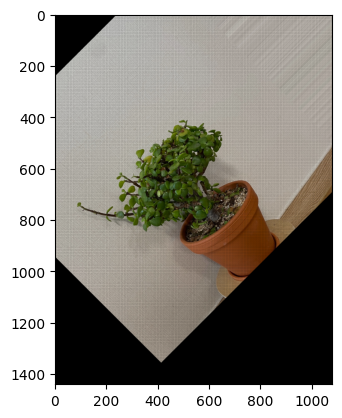

In [19]:
plt.imshow(canvas)

In [59]:
# TODO : SIFT descriptor 간 비교를 위해 1D search space가 필요하다. (epipolar line)

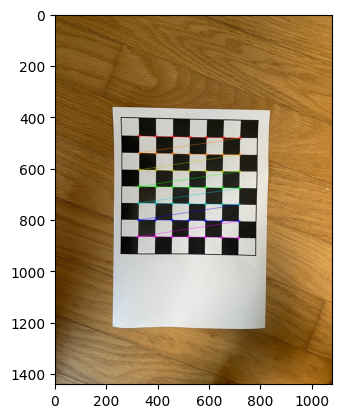

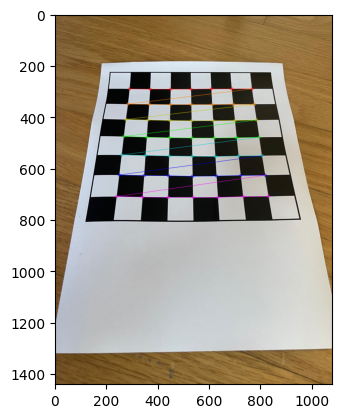

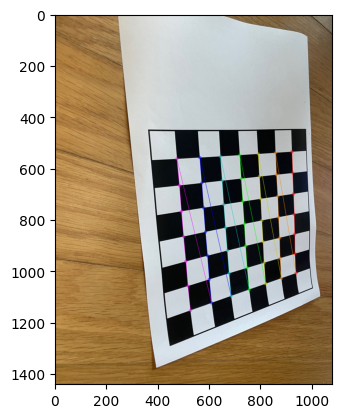

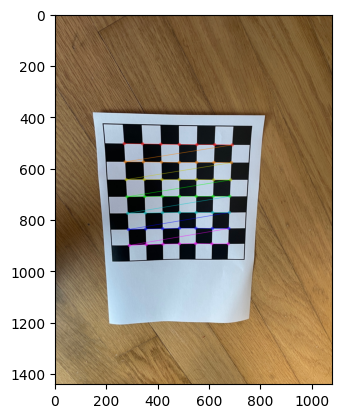

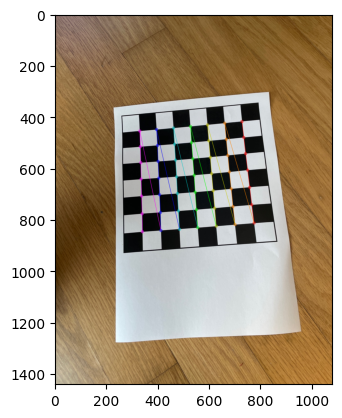

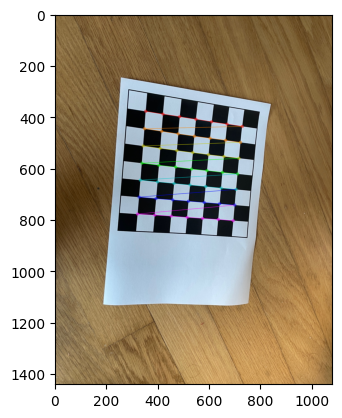

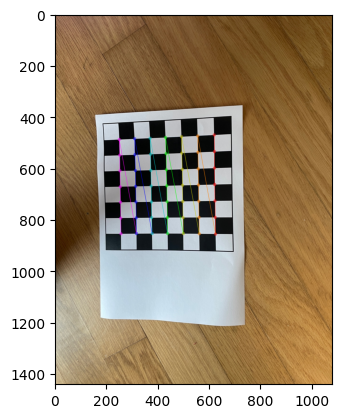

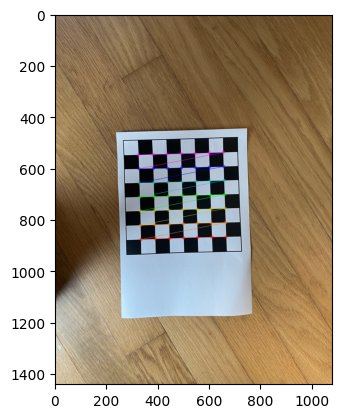

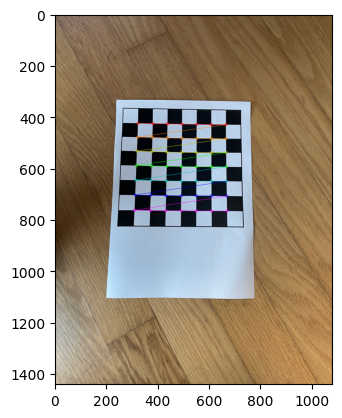

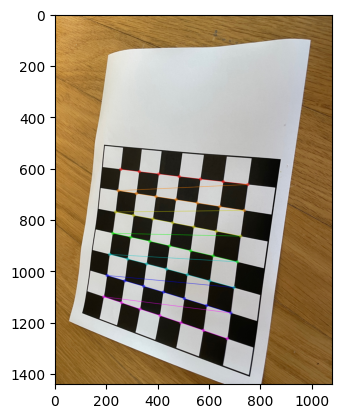

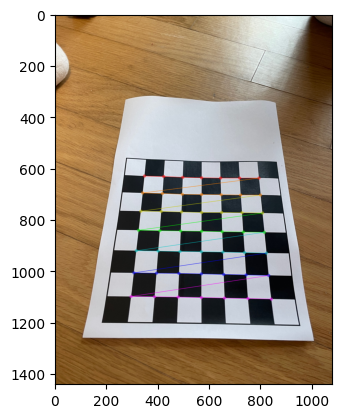

In [60]:
## chessboard calibration
chessboard_files = glob('img/capture_chessboard*.jpg')

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0), ...,
objp = np.zeros((7*7, 3), np.float32)
objp[:,:2] = np.mgrid[0:7, 0:7].T.reshape(-1,2)

# Arrays to store object points and image points from all the images
objpoints = [] # 3d point in real word space
imgpoints = [] # 2d points in image plane

for fname in chessboard_files : 

    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    
    ret, corners = cv2.findChessboardCorners(gray, (7,7), None)

    if ret == True :
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)

        cv2.drawChessboardCorners(img, (7,7), corners2, ret)
        plt.imshow(img[:,:,::-1])
        plt.show()
        


In [61]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [67]:
print(f'fx : {mtx[0][0]}')
print(f'fy : {mtx[1][1]}')

fx : 1095.1543874746635
fy : 1093.6591360300824


In [69]:
left_img = cv2.imread('uncalibrated_images/uncalibrated_left1.jpg')
left_img_gray = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
right_img = cv2.imread('uncalibrated_images/uncalibrated_right1.jpg')
right_img_gray = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)

In [72]:
## ORB 연산
orb = cv2.ORB_create()

kp_left, des_left = orb.detectAndCompute(left_img, None)
kp_right, des_right = orb.detectAndCompute(right_img, None)



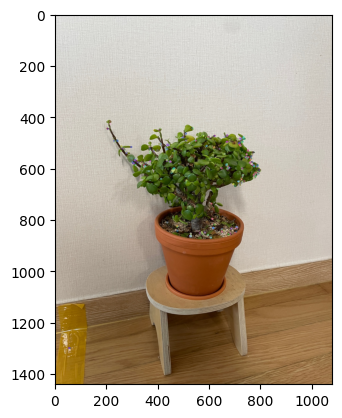

In [73]:
plt.imshow(cv2.drawKeypoints(left_img, kp_left, left_img)[:,:,::-1])

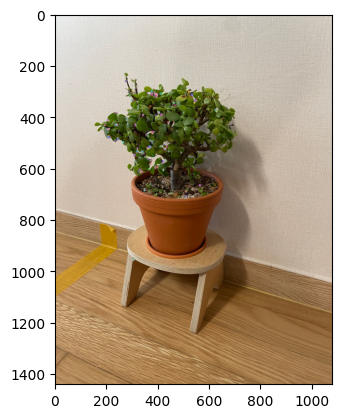

In [74]:
plt.imshow(cv2.drawKeypoints(right_img, kp_right, right_img)[:,:,::-1])

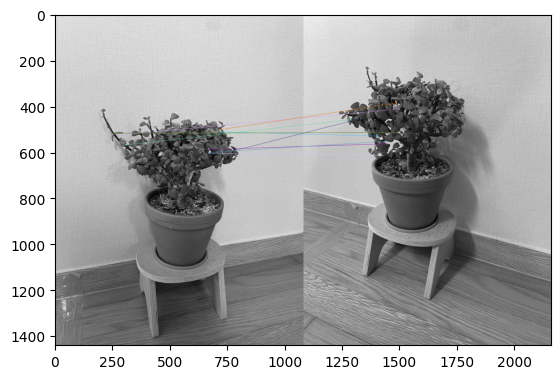

In [75]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)
matches = bf.match(des_left, des_right)

matches = sorted(matches, key = lambda x : x.distance)

img3 = cv2.drawMatches(left_img_gray, kp_left, right_img_gray, kp_right, matches[:10], None, flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(img3)

In [77]:
matches

[< cv2.DMatch 000002460379D1D0>,
 < cv2.DMatch 000002460379E730>,
 < cv2.DMatch 000002460379F450>,
 < cv2.DMatch 000002460379CA90>,
 < cv2.DMatch 0000024603BB86B0>,
 < cv2.DMatch 000002460379C6B0>,
 < cv2.DMatch 000002460379CEF0>,
 < cv2.DMatch 000002460379E3D0>,
 < cv2.DMatch 000002460379D610>,
 < cv2.DMatch 000002460379CA70>,
 < cv2.DMatch 000002460379CD30>,
 < cv2.DMatch 000002460379E0F0>,
 < cv2.DMatch 000002460379E270>,
 < cv2.DMatch 000002460379D970>,
 < cv2.DMatch 000002460379D2B0>,
 < cv2.DMatch 000002460379E410>,
 < cv2.DMatch 000002460379E210>,
 < cv2.DMatch 000002460379DAD0>,
 < cv2.DMatch 000002460379CAB0>,
 < cv2.DMatch 000002460379C770>,
 < cv2.DMatch 000002460379D450>,
 < cv2.DMatch 000002460379CE10>,
 < cv2.DMatch 000002460379E230>,
 < cv2.DMatch 000002460379DD70>,
 < cv2.DMatch 000002460379DB70>,
 < cv2.DMatch 000002460379D670>,
 < cv2.DMatch 000002460379D730>,
 < cv2.DMatch 000002460379CD70>,
 < cv2.DMatch 000002460379C3B0>,
 < cv2.DMatch 000002460379CE50>,
 < cv2.DMa

In [ ]:
## TODO : fundamental matrix(이미 chessboard로 찾았지만)
## TODO : projection matrix를 찾은 후, depth, least square method로 계산